In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import lightgbm

from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [2]:
rep_cols = {'ID':'ID', 
 '板温':'board_t', 
 '现场温度':'env_t', 
 '光照强度':'light_strength', 
 '转换效率':'efficiency', 
 '转换效率A':'efficiency_A', 
 '转换效率B':'efficiency_B', 
 '转换效率C':'efficiency_C', 
 '电压A':'V_A',
 '电压B':'V_B', 
 '电压C':'V_C', 
 '电流A':'I_A', 
 '电流B':'I_B', 
 '电流C':'I_C', 
 '功率A':'P_A', 
 '功率B':'P_B', 
 '功率C':'P_C', 
 '平均功率':'P_avg', 
 '风速':'wind_speed',
 '风向':'wind_direction', 
 '发电量':'y'
}

In [3]:
def my_val(preds, train_data):
    label = train_data.get_label()
    return 'score', 1/(1+np.sqrt(mean_squared_error(preds, label))), True

In [4]:
def my_obj(preds, train_data):
    labels = train_deata.get_label()
    

In [5]:
train = pd.read_csv('../data/public_raw.train.csv')
train['is_train']= 1
test = pd.read_csv('../data/public_raw.test.csv')
test['is_train']=0

train_len = train.shape[0]

df = pd.concat([train, test])

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [6]:
df.rename(index=str, columns=rep_cols, inplace=True)

In [7]:
df.sort_values(by='ID',ascending=True, inplace=True)

In [8]:
df.head()

,ID,is_train,light_strength,P_A,P_B,P_C,y,P_avg,board_t,env_t,...,V_C,I_A,I_B,I_C,efficiency,efficiency_A,efficiency_B,efficiency_C,wind_direction,wind_speed
0,1,0,1,0.00,0.00,0.00,NaN,0.00,0.01,0.1,...,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1,0.1
1,9,0,13,909.72,148.05,1031.03,NaN,696.27,-19.33,-17.5,...,721,1.26,0.21,1.43,198.32,259.11,42.17,293.66,273,0.3
0,10,1,34,976.86,155.98,1087.50,1.437752,740.11,-19.14,-17.4,...,725,1.34,0.22,1.50,80.55,106.32,16.98,118.36,272,0.6
1,11,1,30,1128.40,172.08,1132.56,1.692575,811.01,-18.73,-17.3,...,726,1.55,0.24,1.56,99.90,139.00,21.20,139.51,275,0.8
2,12,1,41,1279.25,166.06,1310.40,1.975787,918.57,-17.54,-17.0,...,720,1.75,0.23,1.82,82.48,114.86,14.91,117.66,283,1.1


In [9]:
def get_ts_feature(df, f_name, prefix='', v_len = 25):
    v = df[f_name].values.tolist()
    # prev
    temp_list = []
    for i in range(df.shape[0]):
#         print("base part:"+str(v[0:20]))
#         print("first part:"+str(v[i-v_len:i]))
#         print("second part:"+str(v[i-v_len:i][::-1]))
        temp_list.append(v[i-v_len:i][::-1])
    temp_df = pd.DataFrame(temp_list)
    temp_df.columns = [prefix+'prev_%d'%x for x in range(v_len)]
    temp_df['ID'] = df['ID'].values
    
    # succ
    temp_list = []
    for i in range(df.shape[0]):
        temp_list.append(v[i+1:i+v_len+1])
    temp_df2 = pd.DataFrame(temp_list)
    temp_df2.columns = [prefix+'succ_%d'%x for x in range(v_len)]
    temp_df2['ID'] = df['ID'].values
    
    temp_df = temp_df.merge(temp_df2, on='ID', how='left')
    return temp_df

In [10]:
#异常值处理
correct_dict = {
    'V_A':(480,60000),
    'V_B':(500,60000),
    'V_C':(500, 60000),
    'I_B':(0, 600),
    'I_C':(0, 30),
    'P_A':(0,10000),
    'P_B':(0,10000),
    'P_C':(0,10000),
    'P_avg':(0,10000)
}
cols = [c for c in df.columns.tolist() if c!='y' and c!='ID']
for c in correct_dict.keys():
    df[c+'_is_out_of_upper'] = (df[c]>correct_dict[c][1]).astype(np.int32)
    df[c+'_is_out_of_lower'] = (df[c]<correct_dict[c][0]).astype(np.int32)

In [19]:
x = get_ts_feature(df, 'light_strength', 'ls')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'env_t', 'env_t')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'y', 'y')
df = df.merge(x, on='ID', how='left')

x = get_ts_feature(df, 'P_avg_corrected', 'pac')
df = df.merge(x, on='ID', how='left')

In [17]:
target = ['P_A','P_avg','I_A','P_C','I_C','P_B','I_B']
target_plus = [c+'_is_out_of_upper' for c in target]+[c+'_is_out_of_lower' for c in target]+target
for c in target:
    df['log_'+c] = np.log1p(df[c])

In [18]:
# 估算功率
df['predict_p_1'] = df['P_A']+df['P_B']+df['P_C']
df['predict_p_2'] = (df['P_A']*df['efficiency_A'] \
                   +df['P_B']*df['efficiency_B'] \
                   +df['P_C']*df['efficiency_C'])/36000

In [13]:
df['P_avg_corrected'] = df['P_avg']

In [14]:
condition = (df['V_A'] > df['V_A'].quantile(0.995)) | ((df['V_A'] < df['V_A'].quantile(0.01)) & (df['V_A'] > 0)) | (df['V_B'] > df['V_B'].quantile(0.995)) | ((df['V_B'] < df['V_B'].quantile(0.01)) & (df['V_B'] > 0))| (df['V_C'] > df['V_C'].quantile(0.995)) | ((df['V_C'] < df['V_C'].quantile(0.01)) & (df['V_C'] > 0))

In [15]:
df.loc[condition , ['P_avg_corrected']]=1/3*df['I_A']*(df['V_A'].median()+df['V_B'].median()+df['V_C'].median())

ValueError: cannot reindex from a duplicate axis

In [16]:
df['P_avg_corrected'].describe()

count     17409.000000
mean       3126.824780
std        7844.852816
min           0.000000
25%        1222.100000
50%        2753.430000
75%        4272.710000
max      202906.540000
Name: P_avg_corrected, dtype: float64

0      0.00
1    696.27
0    740.11
1    811.01
2    918.57
Name: P_avg_corrected, dtype: float64

In [10]:
#前二后二
next_one = []
prev_one = []
next_id = []
prev_id = []

second_next_one = []
second_prev_one = []

df_len = df.shape[0]

i_y =df.columns.get_loc("y")

def get_prev_nn_index(cur_i):
    prev_i = cur_i-1
    while(prev_i>=0 and pd.isnull(df.iat[prev_i,i_y])):
        prev_i-=1
    return prev_i

def get_next_nn_index(cur_i):
    prev_i = cur_i+1
    while(prev_i<df_len and pd.isnull(df.iat[prev_i,i_y])):
        prev_i+=1
    return prev_i

for i in range(df_len):
    f_pre_i=get_prev_nn_index(i)
    if(f_pre_i)<0:
        prev_one.append(np.nan)
        prev_id.append(0)
    else:
        prev_one.append(df.iat[f_pre_i,i_y])
        prev_id.append(f_pre_i)
        
    s_pre_i=get_prev_nn_index(f_pre_i)
    if (s_pre_i)<0:
        second_prev_one.append(np.nan)
    else:
        second_prev_one.append(df.iat[s_pre_i,i_y])
    
    f_next_i=get_next_nn_index(i)
    if(f_next_i<df_len):
        next_one.append(df.iat[f_next_i,i_y])
        next_id.append(f_next_i)
    else:
        next_one.append(np.nan)
        next_id.append(df_len)
    
    s_next_i=get_next_nn_index(f_next_i)
    if(s_next_i<df_len):
        second_next_one.append(df.iat[s_next_i,i_y])
    else:
        second_next_one.append(np.nan)

In [11]:
df['next_value'] = next_one
df['prev_value'] = prev_one
df['avg_value'] = np.nanmean([df['next_value'], df['prev_value']],axis=0)
df['next_ID'] = next_id
df['prev_ID'] = prev_id
# df['interpolation_ID'] = df['prev_value']+(df['ID']-df['prev_ID'])/(df['next_ID']-df['prev_ID'])*(df['next_value']-df['prev_value'])
# df['interpolation_ls'] = df['prev_value']+(df['light_strength']-df['prev_ls'])/(1+df['next_ls']-df['prev_ls'])*(df['next_value']-df['prev_value'])

df['second_prev_value'] = second_prev_one
df['second_next_value'] = second_next_one
# df['avg_value_four'] = np.nanmean([df['second_next_value'],df['next_value'], df['prev_value'],df['second_prev_value']],axis=0)


# df['rolling_seven'] = df['y'].rolling(7,center=True,min_periods=0).apply(lambda x: np.nanmean(x[[0,1,2,4,5,6]]))
rolling_mask_four = [-i for i in range(1,2)]+[i for i in range(1,2)]
rolling_mask_six = [-i for i in range(1,3)]+[i for i in range(1,3)]
rolling_mask_eight = [-i for i in range(1,4)]+[i for i in range(1,4)]
rolling_mask_ten = [-i for i in range(1,5)]+[i for i in range(1,5)]
# df['rolling_four_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_four],axis=0)
# df['rolling_six_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_six],axis=0)
df['rolling_eight_y'] = np.nanmean([df['y'].shift(i) for i in rolling_mask_eight],axis=0)

C:\Users\Alex\Anaconda3\envs\python36\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice


In [12]:
df['magic_feature'] = df['ID']%190

In [20]:
train = df[df['is_train']==1]
test = df[df['is_train']==0]

In [21]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'num_leaves': 31,
    'learning_rate': 0.08,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.9,
    'bagging_freq': 1,
    'verbose': 0
}

In [22]:
predictor = [c for c in train.columns.tolist() if c not in['ID','y','is_train','I_B','I_C']]

In [23]:
len(predictor)

227

In [24]:
test_predicts = []
val_preds = []

# log_test_predicts = []
# log_val_predicts = []
for idx, seed in enumerate([1,2,3,4,5]):
    kf = KFold(5, shuffle=True, random_state=seed)
    
    val_preds.append(np.zeros(train.shape[0]))
    for n_fold, (tra_idx, val_idx) in enumerate(kf.split(train)):
        tra = train.iloc[tra_idx]
        val = train.iloc[val_idx]

        train_set = lightgbm.Dataset(
            tra[predictor],
            tra['y']
        )

        validation_set = lightgbm.Dataset(
            val[predictor],
            val['y']
        )

        model = lightgbm.train(params, train_set, num_boost_round=5000,
                              valid_sets= [validation_set],
                              valid_names=['valid'],
                              early_stopping_rounds=100,
                               feval=my_val,
                              verbose_eval=500)

        val_preds[idx][val_idx] = model.predict(val[predictor])
        test_predicts.append(model.predict(test[predictor]))
        
#         train_set = lightgbm.Dataset(
#             tra[predictor],
#             np.log1p(tra['y'])
#         )

#         validation_set = lightgbm.Dataset(
#             val[predictor],
#             np.log1p(val['y'])
#         )

#         model = lightgbm.train(params, train_set, num_boost_round=5000,
#                               valid_sets= [validation_set],
#                               valid_names=['valid'],
#                               early_stopping_rounds=100,
#                                feval=my_val,
#                               verbose_eval=500)

#         val_preds[idx][val_idx] = np.expm1(model.predict(val[predictor]))
#         test_predicts.append(np.expm1(model.predict(test[predictor])))

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[319]	valid's l2: 0.0668571	valid's score: 0.794554
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0266561	valid's score: 0.859648
Early stopping, best iteration is:
[609]	valid's l2: 0.0264615	valid's score: 0.860089
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[259]	valid's l2: 0.0138147	valid's score: 0.894826
Training until validation scores don't improve for 100 rounds.
[500]	valid's l2: 0.0529562	valid's score: 0.812927
[1000]	valid's l2: 0.0522818	valid's score: 0.8139
[1500]	valid's l2: 0.0521027	valid's score: 0.81416
Early stopping, best iteration is:
[1406]	valid's l2: 0.0520961	valid's score: 0.814169
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[205]	valid's l2: 0.0187719	valid's score: 0.879499
Training until validation scores don't imp

In [25]:
print('local cv:',1/(1+np.sqrt(mean_squared_error(train['y'],np.mean(val_preds,axis=0)))))

local cv: 0.8486268445143639


In [26]:
pd.Series(model.feature_importance(importance_type='gain'),
          index=model.feature_name()).sort_values(ascending=False).head(20)

P_A                  263986.242337
I_A                   78266.410504
P_avg                 77347.452529
P_C                   30872.263191
avg_value             24667.915253
P_avg_corrected       11905.905504
pacprev_0              9656.071930
P_B                    5364.445589
rolling_eight_y        2004.657155
prev_value              719.531034
lssucc_5                158.536553
light_strength          123.997184
wind_direction           97.391555
board_t                  88.552770
efficiency               85.269511
pacsucc_0                70.212765
lssucc_22                67.681045
second_prev_value        64.403646
V_A                      62.583240
pacsucc_18               60.750642
dtype: float64

In [22]:
test['ans'] = np.mean(test_predicts, axis=0)

/Users/wyh/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [23]:
test[['ID','ans']].to_csv('../result/0806-8524-bagging.csv',header=False, index=False)

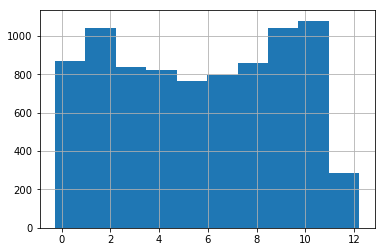

In [19]:
test['ans'].hist()

In [20]:
test['ans'].describe()

count    8409.000000
mean        5.696277
std         3.457993
min        -0.276554
25%         2.523626
50%         5.720650
75%         8.889917
max        12.215004
Name: ans, dtype: float64

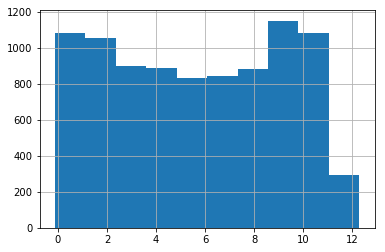

In [21]:
train['y'].hist()

In [22]:
train['y'].describe()

count    9000.000000
mean        5.695245
std         3.463744
min        -0.125144
25%         2.512812
50%         5.769032
75%         8.896220
max        12.288756
Name: y, dtype: float64